# EM Shower Studies on Testbeam Data

**In this session we do the EM shower studies from 2023 testbeam data.**

In [1]:
%load_ext autoreload
%autoreload 2

from emshower import *
from showerrec import *
from robustfit import *
import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.28/04


In [ ]:
# data preparation
# please ignore this block when you are re-run the codes

subarea = "3-3"
file = uproot.open(f"testbeam/root/select{subarea}.root") 
tree = file["tree"]
df = tree.arrays(library="pd")
df.to_csv(f"testbeam/csv/select{subarea}.csv", index=False)
print("CSV file created successfully!")

CSV file created successfully!


### Check the sub-area regions.

- X range
- Y range
- PID range

In [3]:
df = preprocess_data(df)
# print(df.head(10))
# len(df)
df = df[df["PID"]<1000]
print(df["X"].max(), df["X"].min())
print(df["Y"].max(), df["Y"].min())
print(df["PID"].max())
# print(45.0/(df["X"].max()-df["X"].min())/(df["Y"].max()-df["Y"].min()))

43040.61 16971.49
43129.93 17015.408
59


In [4]:
startPID = df['PID'].min()

## Step 1: Pick the primary electron candidates

We don't have event ID information for the real testbeam data. Therefore, we use the same blinded strategy as is described in `truth_MC_study.ipynb`.

Firstly, we pick the tracks starting from the first 3 plates as `primary_trk`.

In [ ]:
df['minPID'] = df.groupby('trkID')['PID'].transform('min')
primary_trk = set(df[df['minPID'] < startPID+3]['trkID'])
print(len(primary_trk))

5417


In [6]:
axis = Seg()
# ntuple = TNtuple("ntuple", "", "plate:x:y:z:tx:ty")
ntuple = pd.DataFrame(columns=['PID', 'X', 'Y', 'Z', 'TX', 'TY'])
# ntProfile = TNtuple("ntProfile", "", "plate:count")
ntProfile = pd.DataFrame(columns=['plate', 'count'])
# ntSegments = TNtuple("ntSegments", "", "d:dt:dmin")
ntSegments = pd.DataFrame(columns=['d', 'dt', 'dmin'])

Here, we only pick the tracks starting from the **1st** plate as **primary tracks**.

In [8]:
# the first hit information
df_primary = df[(df['trkID'].isin(primary_trk))&(df['PID']==df['minPID'])&(df['minPID']==0)]
df_primary.head(10)

,evtID,trkID,segnum,PID,X,Y,Z,TX,TY,E,minPID
26789,-999,128292,15,0,17505.927734,17822.957031,0.0,-0.000535,-0.028246,-999.0,0
160061,-999,128456,51,0,17146.730469,17987.414062,0.0,0.018546,0.004116,-999.0,0
0,-999,128463,5,0,17889.042969,17440.628906,0.0,0.108727,0.027890,-999.0,0
5,-999,128523,11,0,19475.839844,17725.406250,0.0,-0.081180,0.019653,-999.0,0
16,-999,128602,5,0,18008.257812,17204.447266,0.0,0.017731,0.000278,-999.0,0
21,-999,128689,4,0,20745.890625,17302.566406,0.0,-0.085545,0.022984,-999.0,0
192906,-999,128722,13,0,20950.226562,17651.062500,0.0,0.007166,-0.028712,-999.0,0
25,-999,128723,11,0,20639.480469,17577.820312,0.0,-0.002944,-0.003241,-999.0,0
36,-999,128761,10,0,20829.054688,17949.847656,0.0,-0.008611,-0.001411,-999.0,0
179972,-999,128762,7,0,20403.808594,18221.589844,0.0,-0.040235,-0.006733,-999.0,0


And we did some basic checks:

- `df_track`: all the tracks stored in the sub-area data file.

- `df_track_primary`: the selected primary track candidates.

- `df_primary`: the data frame storing the selected primary tracks

In [9]:
df_track = df['trkID'].unique()
df_track_primary = df_primary['trkID'].unique()
print(f'tracks in total: {len(df_track)}, potential primary tracks: {len(df_track_primary)}')
print(f'segments in total: {len(df)}, segments of a potential primary electron: {len(df_primary)}, total track number: {len(df_track)}')

tracks in total: 19058, potential primary tracks: 4850
segments in total: 215306, segments of a potential primary electron: 4850, total track number: 19058


## Step 2: Initial Axis

The initial axis is obtained by the `initial_axis` function defined in `showerrec.py` as

```python
def initial_axis(segments):
    # use the segments of the primary track on the first 4 plates as an initial axis estimation
    # segments = df["trkID==one_primary_track"]
    max_pid = segments["PID"].max()
    plate = max(4, max_pid)

    segments_new = segments[(segments["PID"]<plate)]
    
    grx, gry = TGraph(), TGraph()
    for _, seg in segments_new.iterrows():
        grx.SetPoint(grx.GetN(), seg["Z"], seg["X"])
        gry.SetPoint(gry.GetN(), seg["Z"], seg["Y"])

    grx.Fit("pol1", "Q")
    gry.Fit("pol1", "Q")

    x = grx.GetFunction("pol1").GetParameter(0)
    y = gry.GetFunction("pol1").GetParameter(0)
    z = 0.0
    tx = grx.GetFunction("pol1").GetParameter(1)
    ty = gry.GetFunction("pol1").GetParameter(1)
    axis = Seg()
    axis.set_attributes(x, y, z, tx, ty)
    return axis
```

We pick up one primary track, and then test if this function works well.

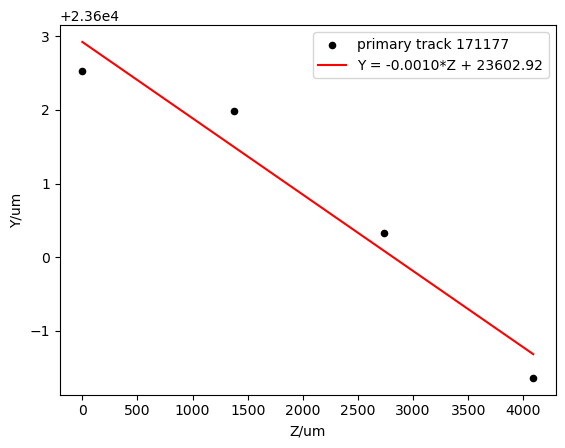

In [38]:
# checks for the primary tracks: pick up one primary track, and then analyze
trackID = 171177
df_one_track = df[(df["trkID"]==trackID)&(df["PID"]<4)]
axis = initial_axis(df_one_track)
plt.scatter(df_one_track['Z'], df_one_track['Y'], c='black', label=f'primary track {trackID}', s=20.0)
x_values = np.linspace(df_one_track['Z'].min(), df_one_track['Z'].max(), 100)
y_values = axis.TY * x_values + axis.Y
plt.plot(x_values, y_values, color='red', label=f'Y = {axis.TY:.4f}*Z + {axis.Y:.2f}')
# plt.ylim(37900, 38100)
plt.xlabel('Z/um')
plt.ylabel('Y/um')
plt.legend()

In [39]:
# 5-5 trkID: 269504, 269510, 269511, 269534, 269535, 269613, 269614, 269615
# check from single track if our methods have any problems

axis_segments = df[df["trkID"]==trackID]
axis.__init__()
axis = initial_axis(axis_segments)

print(axis.TX)
z0 = axis_segments["Z"].min()
print(z0)
#print(axis_segments.head(10))

-0.0005248958254813943
0.0


## Step 3: Count Cylinder Segments

We open a cylinder along the initial axis, and pick the initial segment dataframe.

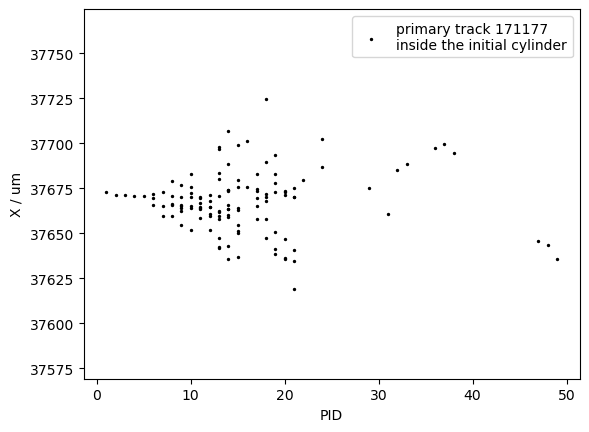

In [40]:
selected_segments = count_cylinder(axis, df, z0)
# selected_segments.head(20)
plt.scatter(selected_segments['PID'], selected_segments['X'], c='black', label=f'primary track {trackID}\ninside the initial cylinder', s=2.0)
plt.ylim(selected_segments["X"].min()-50, selected_segments["X"].max()+50)
plt.xlabel("PID")
plt.ylabel("X / um")
plt.legend()

## Step 4: apply the dbscan method and refit the axis

In [41]:
# centroids = dbscan_for_pid(selected_segments, 18, 2, 10)
centroids = dbscan_for_pid(selected_segments)
centroids.head(20)

,PID,Centroid_X,Centroid_Y,Centroid_Z
0,5.0,37670.636719,23596.007812,6855.230469
1,8.0,37668.511827,23593.673720,10982.267578
2,9.0,37665.164551,23590.985168,12366.675781
3,10.0,37669.499379,23589.732244,13705.226562
4,11.0,37666.537548,23589.901905,15074.122070
5,12.0,37662.393080,23589.959152,16451.541016
6,13.0,37667.375122,23585.556580,17814.203125
7,14.0,37669.468088,23581.216002,19161.289062
8,1.0,37673.152344,23601.982422,1372.916748
9,2.0,37671.500000,23600.326172,2736.564453


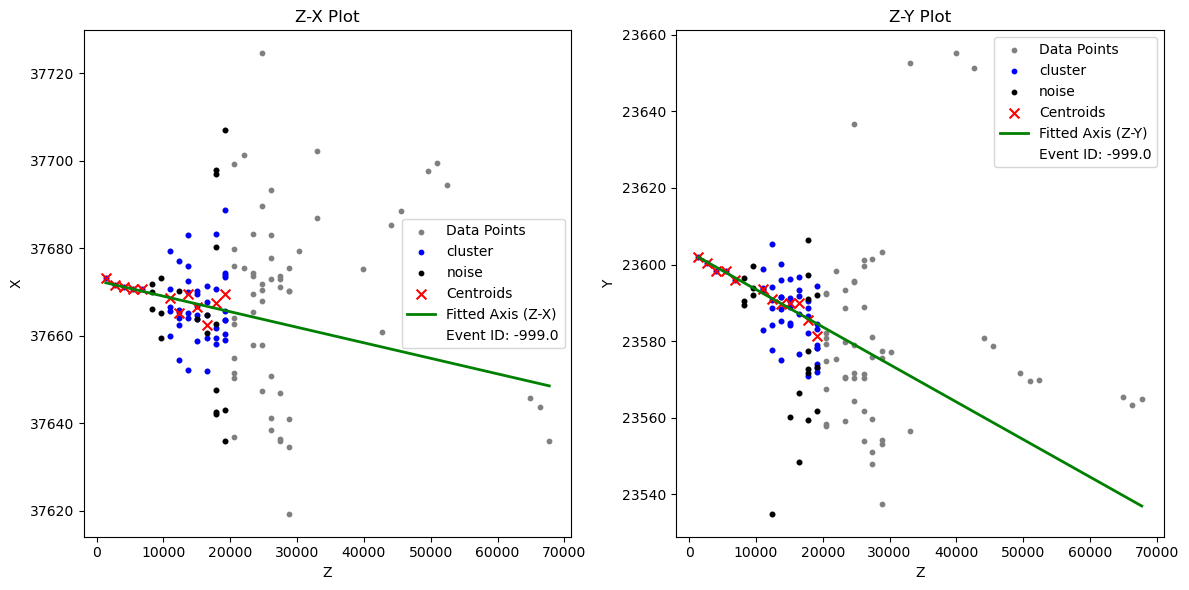

In [42]:
axis_zx, axis_zy = fit_robust_axis(centroids)
plot_centroids(selected_segments, centroids, axis_zx, axis_zy)

## Now, we process the whole testbeam sub-area file with the method introduced above.

In [17]:
df_primary = df_primary.reset_index(drop=True)
shower_profile = pd.DataFrame(columns=['prim_track', 'nsegsum', 'shower_max', 'max_pid', 'shower_start'])

df_cylinder = pd.DataFrame()
eventID = 0
for i, row in df_primary.iterrows():
    if i%100 == 0: print(f"Processing row {i} / {len(df_primary)}")
    # if i<1200: continue
    # if i>1400: break
    
    axis_segments = df[df["trkID"]==row["trkID"]]

    axis.__init__()
    axis = initial_axis(axis_segments)
    
    if(abs(axis.TX)>0.05): continue
    if(abs(axis.TY)>0.05): continue
    # print(axis.TX)
    z0 = row["Z"]
    selected_segments = count_cylinder(axis, df, z0)
    # if(len(selected_segments)>3): print(f'pri_trkID={row["trkID"]} cylinder contains {len(selected_segments)}')
    if(len(selected_segments)<2): continue
    centroids = dbscan_for_pid(selected_segments)
    if(len(centroids)>1):
        axis_zx, axis_zy = fit_robust_axis(centroids)
        axis.set_attributes(axis_zx[1], axis_zy[1], 0.0, axis_zx[0], axis_zy[0])
    selected_segments_refit = count_cylinder(axis, df, z0)
    if(len(selected_segments_refit)<2): continue

    selected_segments_refit["evtID"] = eventID
    eventID += 1
    
    profile = selected_segments_refit.groupby('PID').size().reset_index(name='count')
    profile.columns = ['PID', 'count']
    shower_max = profile['count'].max()
    max_pid = int(profile.loc[profile['count'] == shower_max, 'PID'].iloc[0])

    pid_range = range(max_pid - 3, max_pid + 4)
    nsegsum = profile[profile['PID'].isin(pid_range)]['count'].sum()

    # if(len(selected_segments)>30): print(f'shower max={shower_max} at PID {max_pid}, nsegsum={nsegsum}')
    grouped = selected_segments_refit.groupby(["PID"])["trkID"].nunique()
    filtered = grouped[grouped > 1]
    if len(filtered)>0:
        min_pid_start = int(filtered.index.get_level_values('PID').min())
    else:
        min_pid_start = 10000

    shower_profile = pd.concat([shower_profile, pd.DataFrame([{'prim_track': row["trkID"], 'nsegsum': nsegsum, 'shower_max': shower_max, 'max_pid': max_pid, 'shower_start': min_pid_start}])
    ], ignore_index=True)

    df_cylinder = pd.concat([df_cylinder, selected_segments_refit], ignore_index=True)

Processing row 0 / 4850
Processing row 100 / 4850
Processing row 200 / 4850
Processing row 300 / 4850
Processing row 400 / 4850
Processing row 500 / 4850
Processing row 600 / 4850
Processing row 700 / 4850
Processing row 800 / 4850
Processing row 900 / 4850
Processing row 1000 / 4850
Processing row 1100 / 4850
Processing row 1200 / 4850
Processing row 1300 / 4850
Processing row 1400 / 4850
Processing row 1500 / 4850
Processing row 1600 / 4850
Processing row 1700 / 4850
Processing row 1800 / 4850
Processing row 1900 / 4850
Processing row 2000 / 4850
Processing row 2100 / 4850
Processing row 2200 / 4850
Processing row 2300 / 4850
Processing row 2400 / 4850
Processing row 2500 / 4850
Processing row 2600 / 4850
Processing row 2700 / 4850
Processing row 2800 / 4850
Processing row 2900 / 4850
Processing row 3000 / 4850
Processing row 3100 / 4850
Processing row 3200 / 4850
Processing row 3300 / 4850
Processing row 3400 / 4850
Processing row 3500 / 4850
Processing row 3600 / 4850
Processing ro

In [18]:
df_cylinder.head(10)

,evtID,trkID,segnum,PID,X,Y,Z,TX,TY,E,minPID
0,0,128292.0,15.0,1.0,17510.128906,17785.750000,1372.916748,0.001922,-0.030961,-999.0,0.0
1,0,128292.0,15.0,2.0,17516.283203,17743.304688,2736.564453,0.003529,-0.031317,-999.0,0.0
2,0,128292.0,15.0,3.0,17523.021484,17702.830078,4089.086670,0.004289,-0.029008,-999.0,0.0
3,0,128292.0,15.0,5.0,17544.623047,17632.156250,6855.230469,0.006305,-0.024005,-999.0,0.0
4,0,128292.0,15.0,6.0,17553.539062,17596.111328,8214.138672,0.001596,-0.026795,-999.0,0.0
5,0,128292.0,15.0,7.0,17548.460938,17559.271484,9609.171875,-0.006292,-0.028434,-999.0,0.0
6,0,128292.0,15.0,8.0,17545.056641,17521.800781,10982.267578,-0.004320,-0.028850,-999.0,0.0
7,0,128292.0,15.0,9.0,17544.847656,17488.677734,12366.675781,-0.003036,-0.023302,-999.0,0.0
8,0,128292.0,15.0,10.0,17543.154297,17460.380859,13705.226562,-0.003259,-0.023030,-999.0,0.0
9,0,128292.0,15.0,11.0,17541.154297,17427.728516,15074.122070,0.000470,-0.025371,-999.0,0.0


#### Store the cylinders

In [19]:
print(len(df_cylinder))
df_cylinder.head(10)
df_cylinder.to_csv(f"testbeam/cylinder/cylinder{subarea}.csv", index=False)

101452


#### Store the shower information

In [20]:
shower_profile.head(20)
shower_profile.to_csv(f"testbeam/shower/shower{subarea}.csv", index=False)

## Shower Selection Criteria Studies

Let's first briefly draw the variable distributions of all events before shower selections.

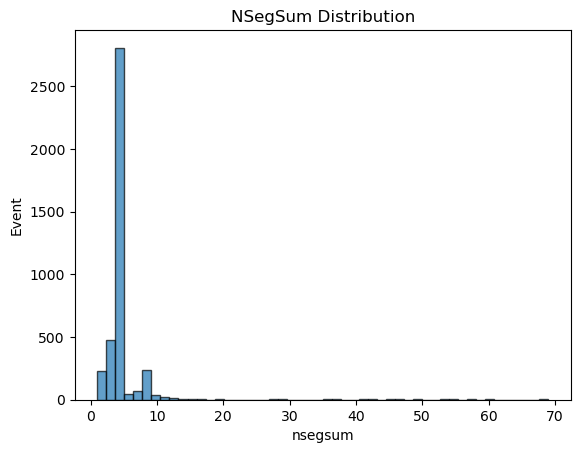

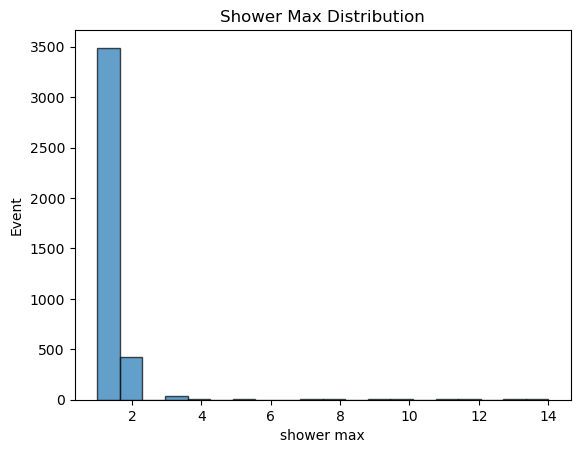

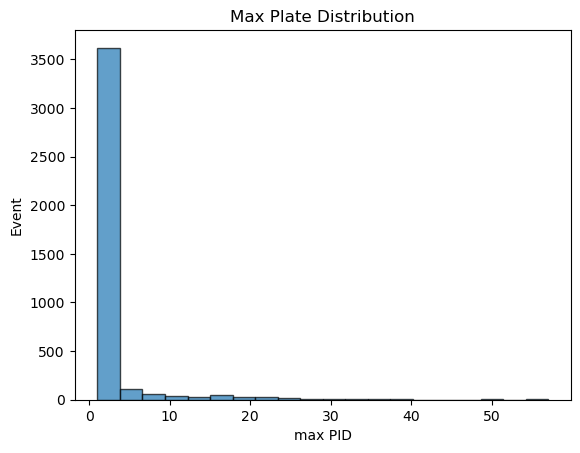

In [22]:
plt.hist(shower_profile["nsegsum"], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('nsegsum')
plt.ylabel('Event')
plt.title('NSegSum Distribution')
plt.show()

plt.hist(shower_profile["shower_max"], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('shower max')
plt.ylabel('Event')
plt.title('Shower Max Distribution')
plt.show()

plt.hist(shower_profile["max_pid"], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('max PID')
plt.ylabel('Event')
plt.title('Max Plate Distribution')
plt.show()

### **Shower Selection Criteria**

Referring to the electron MC, we define the shower selections as:

🍭 **NSegSum > 30**

🍭 **Shower Max > 5**

🍭 **Shower Max Plate in (7, 32)**

In [23]:
elec_profile = shower_profile[(shower_profile["nsegsum"]>30) & (shower_profile["shower_max"]>5) & (shower_profile["max_pid"]>7) & (shower_profile["max_pid"]<32)]
print(f"EM shower: {len(elec_profile)}")
x_len = df["X"].max() - df["X"].min()
#print(x_len)
y_len = df["Y"].max() - df["Y"].min()
#print(y_len)
density = len(elec_profile) / (x_len * y_len)
print(f"Shower density: {density}")

EM shower: 35
Shower density: 5.141142034372113e-08


Define the gaussian plotting function **`plot_gaussian`** the same as in `truth_MC_study.ipynb`:

In [24]:
def plot_gaussian(nsegsum, text='NSegSum', binning=50, fit_resolution=True):
    from scipy.optimize import curve_fit

    # Calculate key statistics
    mean_val = np.mean(nsegsum)
    median_val = np.median(nsegsum)
    std_val = np.std(nsegsum)
    max_val = np.max(nsegsum)
    min_val = np.min(nsegsum)

    # Plot histogram
    hist, bins, _ = plt.hist(nsegsum, bins=binning, alpha=0.7, edgecolor='black')
    plt.xlabel(text)
    plt.ylabel('Event')
    plt.title(f'{text} Distribution')

    # Fit a Gaussian curve
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Get bin centers

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., mean_val, std_val]

    coeff, var_matrix = curve_fit(gauss, bin_centers, hist, p0=p0)

    #print('Fitted mean = ', coeff[1])
    #print('Fitted standard deviation = ', coeff[2])

    # Add key statistics as text on the plot

    stats_text = (
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Std Dev: {std_val:.2f}\n"
        f"Resolution: {std_val/mean_val*100:.2f}%"
        # f"Min: {min_val:.2f}\n"
        # f"Max: {max_val:.2f}"
    )

    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round", facecolor="none", edgecolor="none", alpha=0.8))

    if fit_resolution:
        # Get the fitted curve
        hist_fit = gauss(bin_centers, *coeff)

        plt.plot(bin_centers, hist_fit, color='red')
        
        fit_text = (
            f"Fitted Mean: {coeff[1]:.2f}\n"
            f"Fitted Std Dev: {coeff[2]:.2f}\n"
            f"Fitted Resolution: {coeff[2]/coeff[1]*100:.2f}%"
        )
        plt.text(0.7, 0.95, fit_text, transform=plt.gca().transAxes, fontsize=7, color="blue",
            verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round", facecolor="none", edgecolor="none", alpha=0.8))
    
    plt.show()

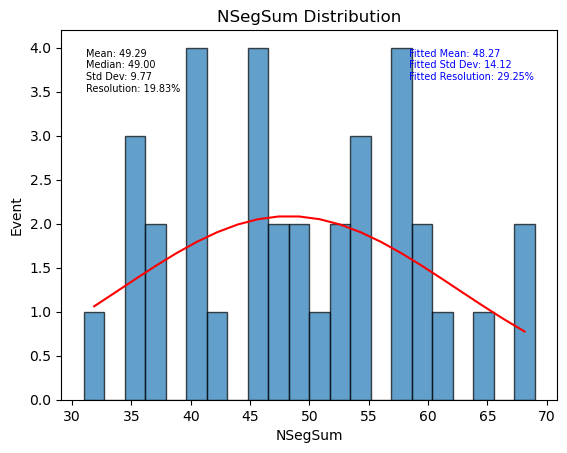

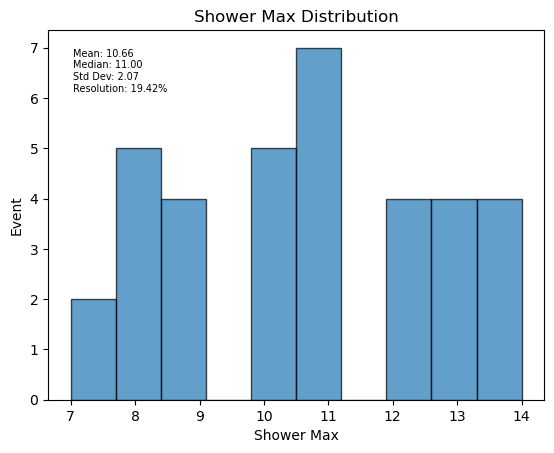

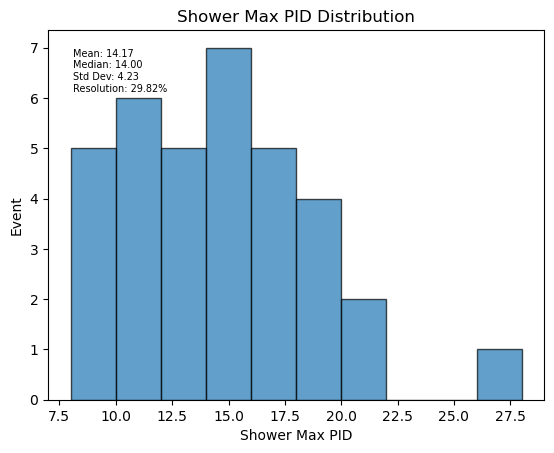

In [33]:
plot_gaussian(elec_profile["nsegsum"], text="NSegSum", binning=22)
plot_gaussian(elec_profile["shower_max"], text="Shower Max", binning=10, fit_resolution=False)
plot_gaussian(elec_profile["max_pid"], text="Shower Max PID", binning=10, fit_resolution=False)

## Sum up All the EM Shower Testbeam Data

We didn't exclude the overlapping region for this! Which means the tracks in the overlapped area will highly likely be counted twice.

In [34]:
# sum up all the EM shower testbeam data

import glob
csv_files = glob.glob("testbeam/shower/*.csv")
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)
elec_profile = combined_df[(combined_df["nsegsum"]>30) & (combined_df["shower_max"]>5) & (combined_df["max_pid"]>7) & (combined_df["max_pid"]<32)]

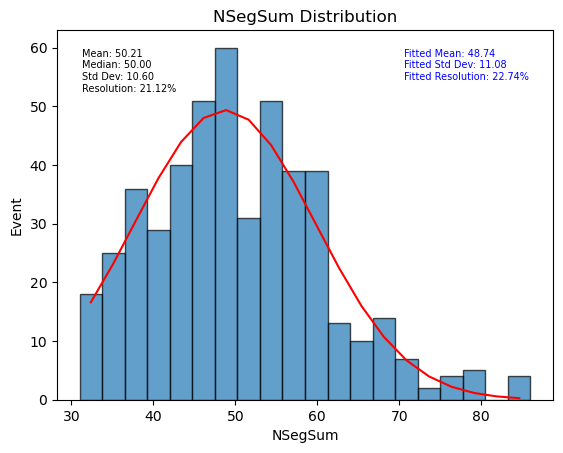

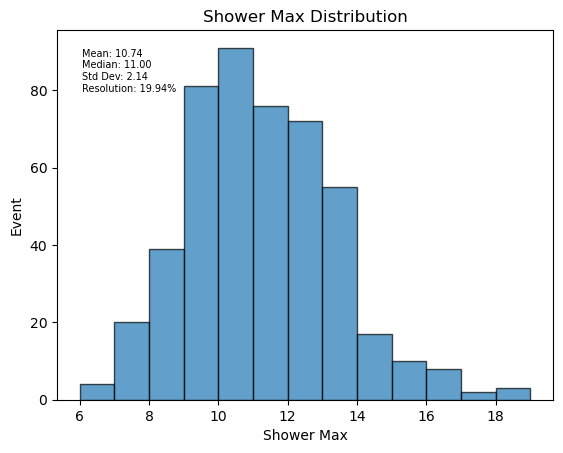

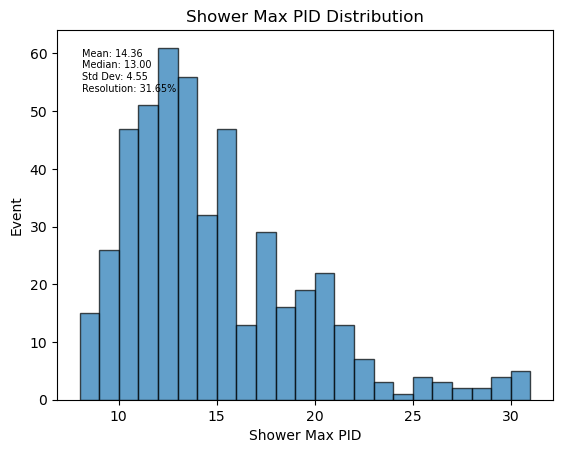

In [37]:
plot_gaussian(elec_profile["nsegsum"], text="NSegSum", binning=20)
plot_gaussian(elec_profile["shower_max"], text="Shower Max", binning=13, fit_resolution=False)
plot_gaussian(elec_profile["max_pid"], text="Shower Max PID", binning=23, fit_resolution=False)